In [1]:
import numpy as np
import pandas as pd
from pylab import *
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast, SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
sns.set()
from pmdarima.arima import ndiffs

# Introduction

The aim of this project is to apply algorithms to find the most accurate prediction for monthly Australian beer production for the year 1996. Although the database provided covers decades (1956-1995), it contains only two columns: Data and beer production.
Intuition tells us that there are several factors that can influence beer production in a particular country, including temperature, price, advertising, but also national and international economic and political factors such as: shortage of ingredients for beer, inflation or the government's intention to reduce per capita alcohol consumption.

Under a logical assumption, we believe that all these factors could be taken into account and would create models with a much higher predictability.

# Setup

* Describe and explain the steps (code) you are taking - why is it there and what is it doing.
* Summarize the forecast and give a comment on what you did, why you did what you did, and how you ended up with the final forecast.
* If you think it is beneficial, compare at least two machine learning models and explain, which is better
* If you are using only one model, explain why you chose exactly this one and why do you think it is the most suitable for the task at hand

In [2]:
dfbeer = pd.read_csv("D:/Kaggle/datasets_56102_107707_monthly-beer-production-in-austr.csv")
dfbeer['Month'] = pd.to_datetime(dfbeer['Month'])
dfbeer.index = dfbeer['Month'] 
dfbeer.tail()

,Month,Monthly beer production
Month,,
1995-04-01,1995-04-01,127.0
1995-05-01,1995-05-01,151.0
1995-06-01,1995-06-01,130.0
1995-07-01,1995-07-01,119.0
1995-08-01,1995-08-01,153.0


In [4]:
dfbeer["Month"] = pd.to_datetime(dfbeer["Month"])
pd.date_range(min(dfbeer["Month"]),max(dfbeer["Month"]),freq='MS') # getting 476 month between min and max dates, equals to data length

DatetimeIndex(['1956-01-01', '1956-02-01', '1956-03-01', '1956-04-01',
               '1956-05-01', '1956-06-01', '1956-07-01', '1956-08-01',
               '1956-09-01', '1956-10-01',
               ...
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01', '1995-05-01', '1995-06-01',
               '1995-07-01', '1995-08-01'],
              dtype='datetime64[ns]', length=476, freq='MS')

# EDA

By plotting the data, we can notice the following:

* Seasonal component amplitude increases over time - probably using log transformation would be beneficial.
* Uppward linear trend until around 1975, and a structural change afterwards. For the rest of the period, there seems to be no trend component

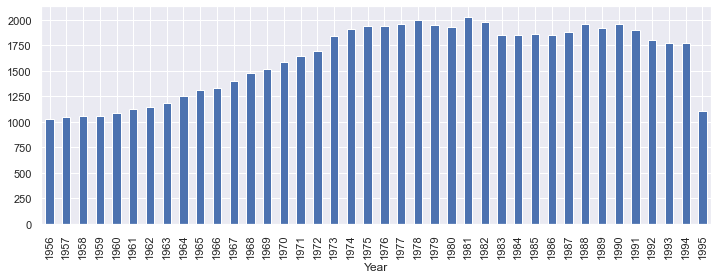

In [5]:
# Yearly production
dfbeer['Year'] = pd.DatetimeIndex(dfbeer['Month']).year
dfbeer.groupby(['Year']).sum()['Monthly beer production'].plot(figsize=(12,4), kind='bar');

<AxesSubplot:xlabel='Month'>

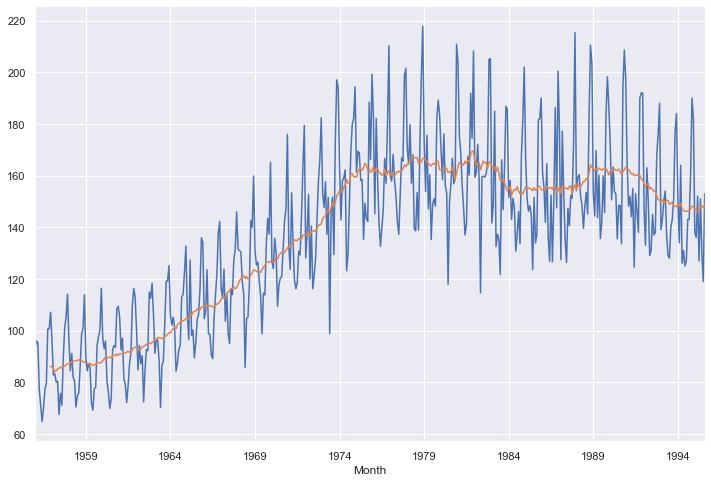

In [103]:
# Trend with average
dfbeer['Monthly beer production'].plot()
dfbeer['Monthly beer production'].rolling(12).mean().plot()

We can notice the following:
1) the time series is not stationary (we could use some test to test the hypothesis) 
2) there has been a regime change from upward trending to lightly downward trending 
3) the volatility seem to increase in time (we could analyse the changes or residuals after fitting trendline)

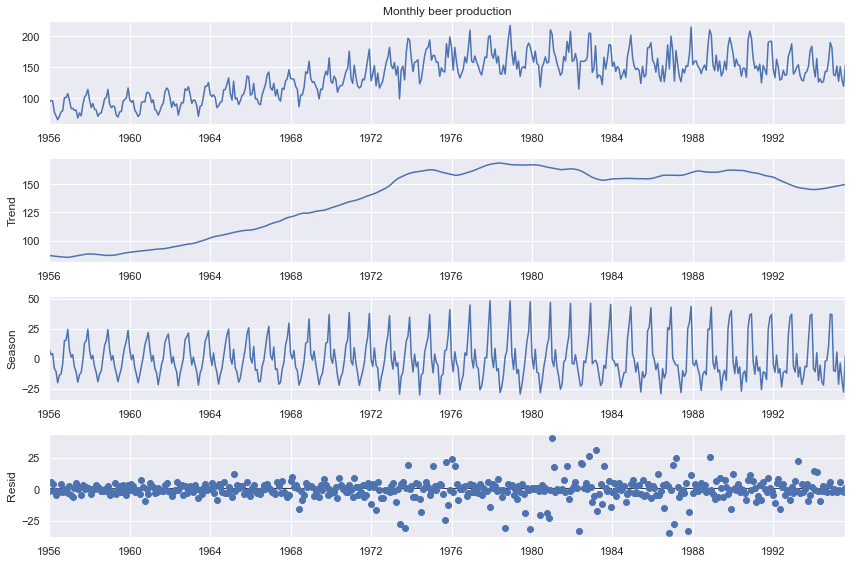

In [104]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import STL
plt.rc('figure',figsize=(12, 8))

stl = STL(dfbeer['Monthly beer production'], period=12, robust=True)
result = stl.fit()
fig = result.plot() # trend narrows since 1975

### Augumented Test
Augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample

In [22]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries, cutoff = 0.05):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adf_test[4].items():
       adf_output['Critical Value (%s)'%key] = value
    pvalue = adf_test[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
        
    print (adf_output)

#apply adf test on the series
adf_test(dfbeer['Monthly beer production'])

Results of Dickey-Fuller Test:
p-value = 0.1776. The series is likely non-stationary.
Test Statistic                  -2.282661
p-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
ACF shows how correlated the values in a time series are with itself (with a lag), PACF captures the correlation between time series and its lagged version after controlling for the effects of other (previous) lags.

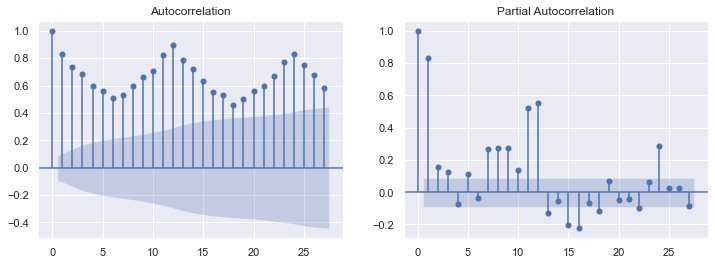

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_correlations(series):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(series, ax = axes[0])
    plot_pacf(series, ax = axes[1])
    
plot_correlations(dfbeer['Monthly beer production'])


* Observations: 
Time series is non-stationary due to significant dependence among values.

Following the test we bring the data trough log transformation. When our original continuous data do not follow the bell curve, we can log transform this data to make it as “normal” as possible so that the statistical analysis results from this data become more valid. In other words, the log transformation reduces or removes the skewness of our original data.

<AxesSubplot:xlabel='Month'>

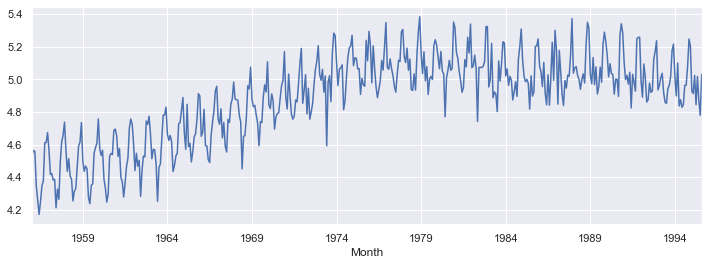

In [24]:
dfbeer['production_log'] = np.log(dfbeer['Monthly beer production'])
dfbeer['production_log'].plot(figsize=(12,4))

<AxesSubplot:xlabel='Month'>

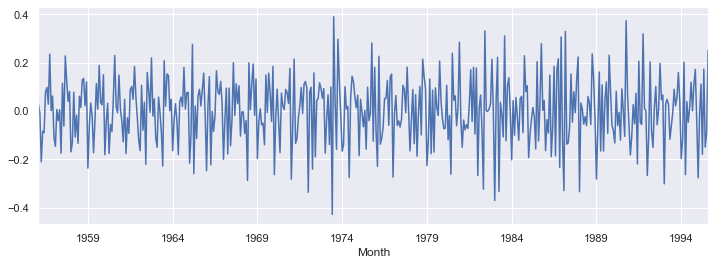

In [105]:
#Differencing
# One of the most common methods of dealing with both trend and seasonality - taking the difference with a particular time lag
dfbeer['production_log_diff_1'] = dfbeer['production_log'].diff()
dfbeer['production_log_diff_1'].dropna().plot(figsize=(12, 4))

* Checking stationarity

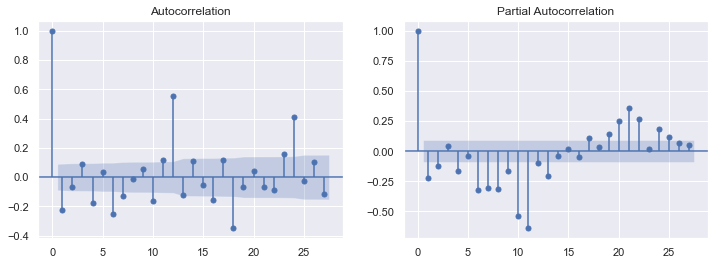

In [28]:
plot_correlations(dfbeer['production_log_diff_1'].dropna())

In [29]:
adf_test(dfbeer['production_log_diff_1'].dropna())

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -4.869646
p-value                          0.000040
#Lags Used                      18.000000
Number of Observations Used    456.000000
Critical Value (1%)             -3.444772
Critical Value (5%)             -2.867899
Critical Value (10%)            -2.570157
dtype: float64


The data seems to be stationary, therefore rejecting the null hypothesis.

# Forecasting

Given the available data, several algorithms for forecasting can be considered:

1) Autoregressive Integrated Moving Average (ARIMA): one of the most used models for series forecasting. It explains a given time series based on its own past values.

2) Vector Autoregression (VAR): is a forecasting algorithm that can be used when two or more time series influence each other. 
However, our data is univariate while VAR is made for bivariate or multivariate data. Therefore this alghorithm cannot be considered.

3) Seasonal Autoregressive Integrated Moving Average (SARIMA): It is an extension of basic ARIMA models and alow for the incorporation of seasonal patterns.
Due to the nature of our data, which contains seasons, this is one of the algorithms we are going to use.

4) Exponential Smoothing (ES): A time series forecasting method for univariate data that can be extended to support data with a systematic trend or seasonal component.
We are considering this model for our analysis.

5) Linear Regression: A model that assumes a linear relationship between the input variables (x) and the single output variable (y). More specifically, that y can be calculated from a linear combination of the input variables (x)

Linear Regression is one of the most simple algorithms and features similar to SARIMA can be created. We consider this model because sometimes simpler algorithms perform much better than complex ones. 

6) LSTM: Long Short-Term Memory (LSTM) is a type of recurrent neural network that can learn the order dependence between items in a sequence. It is often used to solve time series forecasting problems.

7) DeepAR: DeepAR developed by Amazon is a probabilistic forecasting model based on autoregressive recurrent neural networks.

8) N-BEATS: N-BEATS is a custom Deep Learning algorithm which is based on backward and forward residual links for univariate time series point forecasting.



* Deep Learning Models? 

Numbers 5, 6 and 7 represent deep learning models. We consider these models to be unsuitable for the database because these models require much more complex and larger databases, as they require a lot of data to train on.

Considering the information above, we decided to use 3 different techniques - SARIMA, Linear Regression, and Exponential Smoothing. There are several metrics that could be useful to evaluate the performance of the model. 

### Performance Evaluation

Since our models imply a regression problem, we will use the following metrics for evaluation:

* Mean Squared Error (MSE): tells you how close a regression line is to a set of points. It does this by taking the distances from the points to the regression line (these distances are the “errors”) and squaring them.
* Mean Absolute Error (MAE): is the amount of error in your measurements
* Root Mean Squared Error (RMSE): it tells you how concentrated the data is around the line of best fit.
* Mean Absolut Percentage Error (MAPE): is a measure of how accurate a forecast system is and it measures this accuracy as a percentage.
* R2: R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. Whereas correlation explains the strength of the relationship between an independent and dependent variable, R-squared explains to what extent the variance of one variable explains the variance of the second variable. So, if the R2 of a model is 0.50, then approximately half of the observed variation can be explained by the model's inputs.

Both RMSE and R2 quantify how well a regression model fits a dataset. The RMSE tells us how well a regression model can predict the value of the response variable in absolute terms while R2 tells us how well a model can predict the value of the response variable in percentage terms.

Given the nature of the analysis, we will look in particular at the following metrics: R2, RMSE and MAPE.

In [32]:
horizon = 16 # we are going to provide a forecast for the whole year 1996, having data till August 1995, therefore having 16 months.
# splitting data
data_train = dfbeer.iloc[:-horizon]
data_validation = dfbeer.iloc[-horizon:]

In [33]:
data_validation

,Month,Monthly beer production,Year,production_log,production_log_diff_1
Month,,,,,
1994-05-01,1994-05-01,131.0,1994,4.875197,0.038915
1994-06-01,1994-06-01,125.0,1994,4.828314,-0.046884
1994-07-01,1994-07-01,127.0,1994,4.844187,0.015873
1994-08-01,1994-08-01,143.0,1994,4.962845,0.118658
1994-09-01,1994-09-01,143.0,1994,4.962845,0.000000
1994-10-01,1994-10-01,160.0,1994,5.075174,0.112329
1994-11-01,1994-11-01,190.0,1994,5.247024,0.171850
1994-12-01,1994-12-01,182.0,1994,5.204007,-0.043017
1995-01-01,1995-01-01,138.0,1995,4.927254,-0.276753


# Baseline Metrics

In [34]:
from sklearn import metrics
import datetime
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import datetime

# We imported the metrics necessary for the evaluation of all models.

def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    print('Evaluation metric results:')
    print(f'MSE is : {mse}')
    print(f'MAE is : {mae}')
    print(f'RMSE is : {rmse}')
    print(f'MAPE is : {mape}')
    print(f'R2 is : {r2}',end='\n\n')
    return [mse, mae, rmse, mape, r2]

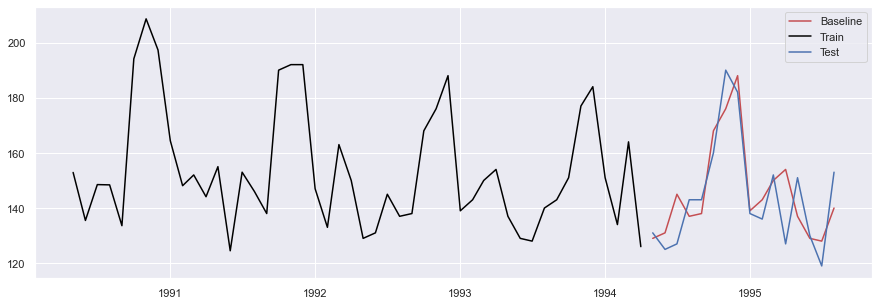

In [35]:
forecast = pd.DataFrame(np.array(data_train['Monthly beer production'][datetime.datetime(1992,5,1):datetime.datetime(1993,8,1)]), index = data_validation.index)
forecast.columns = ['Baseline']

#graph
def plot_forecast(data_train, data_validation, forecast):
    plt.figure(figsize=(15, 5))
    plt.plot(forecast['Baseline'], color='r')
    plt.plot(data_train['Monthly beer production'].iloc[-48:], color='black')
    plt.plot(data_validation['Monthly beer production'], color='b')
    plt.legend(['Baseline', 'Train', 'Test']);
    
plot_forecast(data_train, data_validation, forecast)

In [36]:
forecast.head()

,Baseline
Month,
1994-05-01,129.0
1994-06-01,131.0
1994-07-01,145.0
1994-08-01,137.0
1994-09-01,138.0


In [37]:
actual = np.array(dfbeer['Monthly beer production'][-horizon:])
metrics_baseline = timeseries_evaluation_metrics_func(actual,forecast['Baseline'])
metrics_forecast = pd.DataFrame(metrics_baseline, index = ['MSE', 'MAE', 'RMSE', 'MAPE', 'R2'])
metrics_forecast.columns = ['Baseline']
metrics_forecast

Evaluation metric results:
MSE is : 121.9375
MAE is : 8.6875
RMSE is : 11.042531412678889
MAPE is : 6.150326101729737
R2 is : 0.6770101503409314



,Baseline
MSE,121.937500
MAE,8.687500
RMSE,11.042531
MAPE,6.150326
R2,0.677010


### Results
For a basic model with only 16 months analyzed, the model did quite well in predicting 67.7% of the variation.
At the same time the MAPE is about 6.15% and every model below 10% is considered very good.

# Models
The project is going to use 3 models:

* SARIMA 
* Linear Regression
* Exponential Smoothing


## SARIMA

In [49]:
import pmdarima as pm

In [50]:
# d = 1 (timeseries should be differenced once to become stationary, as we figured out before)

model = pm.auto_arima(data_train['Monthly beer production'], start_p = 0, start_q = 0,
                      max_p = 4, d = 1, max_q = 4, information_criterion='aic',
                      test = 'adf', max_P=3, max_D=1, max_Q=3, m=12, trace=True,
                      maxiter = 50, stepwise = True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4038.318, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3778.427, Time=0.39 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3807.061, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4036.324, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4015.288, Time=0.08 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3754.656, Time=1.99 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=3742.717, Time=4.82 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=3650.459, Time=5.49 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(1,1,0)(3,0,2)[12] intercept   : AIC=inf, Time=11.63 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=6.57 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=inf, Time=5.49 sec
 ARIMA(2,1,0)(3,0,1)[12] intercept   : AIC=3537.018, Time=7.89 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=

In [51]:
model_log = pm.auto_arima(data_train['production_log'], start_p = 0, start_q = 0,
                      max_p = 4, d = 1, max_q = 4, information_criterion='aic',
                      test = 'adf', max_P=3, max_D=1, max_Q=3, m=12, trace=True,
                      maxiter = 50, stepwise = True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-525.472, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-792.779, Time=0.69 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-737.661, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-527.461, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-546.742, Time=0.14 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-814.834, Time=2.40 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=-826.096, Time=5.40 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=-896.618, Time=7.27 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(1,1,0)(3,0,2)[12] intercept   : AIC=inf, Time=8.26 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=4.34 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=-773.289, Time=5.88 sec
 ARIMA(2,1,0)(3,0,1)[12] intercept   : AIC=-1015.637, Time=8.77 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   :

Plotting the forecasts with confidence intervals:

In [52]:
print(model.summary())
print(model_log.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  460
Model:             SARIMAX(4, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -1703.946
Date:                                 Wed, 30 Mar 2022   AIC                           3425.893
Time:                                         16:47:54   BIC                           3463.054
Sample:                                              0   HQIC                          3440.528
                                                 - 460                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2305      0.058     -4.004      0.000      -0.343      -0

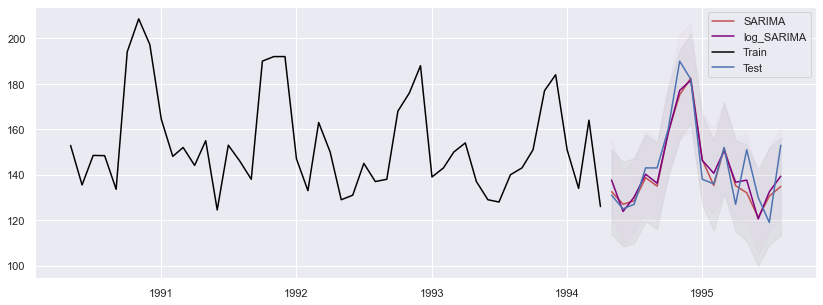

In [53]:
forecast_mean_ci = model.predict(n_periods = horizon, return_conf_int=True)
forecast['SARIMA'] = forecast_mean_ci[0]
forecast[['upper_ci','lower_ci']] = forecast_mean_ci[1]

forecast_log_mean_ci = model_log.predict(n_periods = horizon, return_conf_int=True)
forecast['log_SARIMA'] = np.exp(forecast_log_mean_ci[0])
forecast[['log_upper_ci','log_lower_ci']] = np.exp(forecast_log_mean_ci[1])

#graph
def plot_forecast(data_train, data_validation, forecast):
    plt.figure(figsize=(14, 5))
    plt.plot(forecast['SARIMA'], color='r');
    plt.plot(forecast['log_SARIMA'], color='purple');
    plt.plot(data_train['Monthly beer production'].iloc[-48:], color='black')
    plt.plot(data_validation['Monthly beer production'], color='b')
    plt.fill_between(forecast.index, forecast['upper_ci'], forecast['SARIMA'], alpha = 0.1, color='grey')
    plt.fill_between(forecast.index, forecast['lower_ci'], forecast['SARIMA'], alpha = 0.1, color='grey')
    plt.fill_between(forecast.index, forecast['log_upper_ci'], forecast['log_SARIMA'], alpha = 0.1, color='thistle')
    plt.fill_between(forecast.index, forecast['log_lower_ci'], forecast['log_SARIMA'], alpha = 0.1, color='thistle')
    plt.legend(['SARIMA','log_SARIMA', 'Train', 'Test']);
    
plot_forecast(data_train, data_validation, forecast)

In [106]:
#Creating the metrics
metrics_sarima = timeseries_evaluation_metrics_func(actual,forecast['SARIMA'])
metrics_log_sarima = timeseries_evaluation_metrics_func(actual,forecast['log_SARIMA'])
metrics_forecast['SARIMA'] = metrics_sarima
metrics_forecast['log_SARIMA'] = metrics_log_sarima

Evaluation metric results:
MSE is : 84.40108653769062
MAE is : 6.814322784487761
RMSE is : 9.187006396954919
MAPE is : 4.727062206823411
R2 is : 0.7764371563147454

Evaluation metric results:
MSE is : 68.81845985202027
MAE is : 6.846226543133695
RMSE is : 8.295689233090899
MAPE is : 4.851822592875727
R2 is : 0.8177126478616286



In [55]:
metrics_forecast

,Baseline,SARIMA,log_SARIMA
MSE,121.937500,84.401087,68.818460
MAE,8.687500,6.814323,6.846227
RMSE,11.042531,9.187006,8.295689
MAPE,6.150326,4.727062,4.851823
R2,0.677010,0.776437,0.817713


Below we are going to take the median of time length (1975) for training. 

In [56]:
datetime.datetime(1975,1,1)
train_from_1975 = data_train[datetime.datetime(1975,1,1):]['production_log']

In [57]:
model_from_1975 = pm.auto_arima(train_from_1975, start_p = 0, start_q = 0, 
                      max_p = 4, d = 1, max_q = 4, information_criterion='aic',
                      test = 'adf', max_P=3, max_D=1, max_Q=3, m=12, trace=True,
                      maxiter = 50, stepwise = True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-239.535, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-349.290, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-241.522, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-255.727, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-354.026, Time=1.18 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=-358.957, Time=2.95 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=-391.025, Time=4.30 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.72 sec
 ARIMA(1,1,0)(3,0,2)[12] intercept   : AIC=inf, Time=6.17 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.72 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=inf, Time=4.05 sec
 ARIMA(2,1,0)(3,0,1)[12] intercept   : AIC=-453.680, Time=7.20 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=-447.7

In [58]:
print(model_from_1975.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  232
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 12)   Log Likelihood                 255.901
Date:                            Wed, 30 Mar 2022   AIC                           -495.802
Time:                                    17:10:43   BIC                           -468.262
Sample:                                         0   HQIC                          -484.694
                                            - 232                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.719e-06   4.07e-05     -0.239      0.811   -8.95e-05    7.01e-05
ma.L1         -1.1895      0.070   

In [84]:
#graph
def plot_forecast(data_train, data_validation, forecast):
    plt.figure(figsize=(14,5))
    plt.plot(forecast['log_SARIMA_from_1975'], color='r');
    plt.plot(data_train['Monthly beer production'].iloc[-40:], color='black')
    plt.plot(data_validation['Monthly beer production'], color='b')
    plt.fill_between(forecast.index, forecast['log_upper_ci_from_1975'], forecast['log_SARIMA_from_1975'], alpha = 0.1, color='grey')
    plt.fill_between(forecast.index, forecast['log_lower_ci_from_1975'], forecast['log_SARIMA_from_1975'], alpha = 0.1, color='grey')
    plt.legend(['Forecast', 'Train', 'Test']);

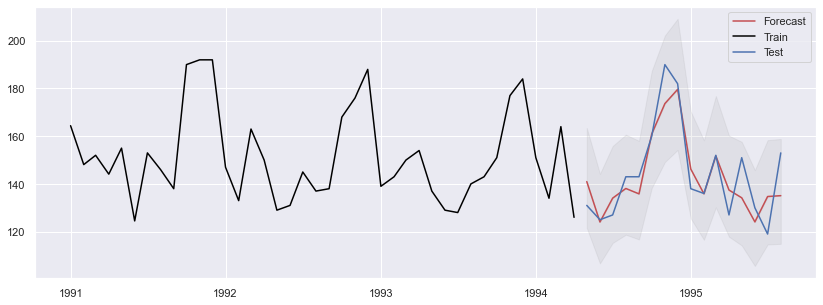

In [85]:
forecast_mean_ci = model_from_1975.predict(n_periods = horizon, return_conf_int=True) 
forecast['log_SARIMA_from_1975'] = np.exp(forecast_mean_ci[0])
forecast[['log_upper_ci_from_1975','log_lower_ci_from_1975']] = np.exp(forecast_mean_ci[1])

    
plot_forecast(data_train, data_validation, forecast)

In [87]:
metrics_log_sarima_from_1975 = timeseries_evaluation_metrics_func(actual,forecast['log_SARIMA_from_1975'])
metrics_forecast['log_SARIMA_from_1975'] = metrics_log_sarima_from_1975
metrics_forecast

Evaluation metric results:
MSE is : 97.5374088849839
MAE is : 7.818678670122447
RMSE is : 9.87610291992666
MAPE is : 5.493870542443199
R2 is : 0.7416414718040303



,Baseline,SARIMA,log_SARIMA,log_SARIMA_from_1975
MSE,121.937500,84.401087,68.818460,97.537409
MAE,8.687500,6.814323,6.846227,7.818679
RMSE,11.042531,9.187006,8.295689,9.876103
MAPE,6.150326,4.727062,4.851823,5.493871
R2,0.677010,0.776437,0.817713,0.741641


Up to present the SARIMA models performed best.

# Linear Regression

In [88]:
dfbeer.head()

,Month,Monthly beer production,Year,production_log,production_log_diff_1
Month,,,,,
1956-01-01,1,93.2,1956,4.534748,NaN
1956-02-01,2,96.0,1956,4.564348,0.029600
1956-03-01,3,95.2,1956,4.555980,-0.008368
1956-04-01,4,77.1,1956,4.345103,-0.210877
1956-05-01,5,70.9,1956,4.261270,-0.083833


In [107]:
dfbeer['Month'] = dfbeer.index.month #Indexing months

In [91]:
dfbeer.head(10)

,Month,Monthly beer production,Year,production_log,production_log_diff_1
Month,,,,,
1956-01-01,1,93.2,1956,4.534748,NaN
1956-02-01,2,96.0,1956,4.564348,0.029600
1956-03-01,3,95.2,1956,4.555980,-0.008368
1956-04-01,4,77.1,1956,4.345103,-0.210877
1956-05-01,5,70.9,1956,4.261270,-0.083833
1956-06-01,6,64.8,1956,4.171306,-0.089965
1956-07-01,7,70.1,1956,4.249923,0.078617
1956-08-01,8,77.3,1956,4.347694,0.097771
1956-09-01,9,79.5,1956,4.375757,0.028063


In [63]:
#12 dummy variables are too many and we modify the structure of the months so we can assign either "1" or "0"
dum_df = pd.get_dummies(dfbeer, columns=["Month"], prefix=["month_n"] )
dum_df.head(3)

,Monthly beer production,Year,production_log,production_log_diff_1,month_n_1,month_n_2,month_n_3,month_n_4,month_n_5,month_n_6,month_n_7,month_n_8,month_n_9,month_n_10,month_n_11,month_n_12
Month,,,,,,,,,,,,,,,,
1956-01-01,93.2,1956,4.534748,NaN,1,0,0,0,0,0,0,0,0,0,0,0
1956-02-01,96.0,1956,4.564348,0.029600,0,1,0,0,0,0,0,0,0,0,0,0
1956-03-01,95.2,1956,4.555980,-0.008368,0,0,1,0,0,0,0,0,0,0,0,0


In [64]:
# Pandas dataframe.shift() function Shift index by desired number of periods with an optional time freq. 
# This function takes a scalar parameter called the period, which represents the number of shifts to be made over the desired axis
dum_df['year_ago'] = dum_df['Monthly beer production'].shift(12)
dum_df['last_month'] = dum_df['Monthly beer production'].shift(1)
dum_df['one_year_trend'] = dum_df['last_month'] - dum_df['year_ago']
dum_df.head(3)

,Monthly beer production,Year,production_log,production_log_diff_1,month_n_1,month_n_2,month_n_3,month_n_4,month_n_5,month_n_6,month_n_7,month_n_8,month_n_9,month_n_10,month_n_11,month_n_12,year_ago,last_month,one_year_trend
Month,,,,,,,,,,,,,,,,,,,
1956-01-01,93.2,1956,4.534748,NaN,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1956-02-01,96.0,1956,4.564348,0.029600,0,1,0,0,0,0,0,0,0,0,0,0,NaN,93.2,NaN
1956-03-01,95.2,1956,4.555980,-0.008368,0,0,1,0,0,0,0,0,0,0,0,0,NaN,96.0,NaN


In [102]:
# Droping NaN's
dum_df.dropna(inplace=True)
dum_df.head(3)

,Monthly beer production,Year,production_log,production_log_diff_1,month_n_1,month_n_2,month_n_3,month_n_4,month_n_5,month_n_6,month_n_7,month_n_8,month_n_9,month_n_10,month_n_11,month_n_12,year_ago,last_month,one_year_trend
Month,,,,,,,,,,,,,,,,,,,
1957-01-01,95.9,1957,4.563306,-0.110457,1,0,0,0,0,0,0,0,0,0,0,0,93.2,107.1,13.9
1957-02-01,82.8,1957,4.416428,-0.146878,0,1,0,0,0,0,0,0,0,0,0,0,96.0,95.9,-0.1
1957-03-01,83.3,1957,4.422449,0.006020,0,0,1,0,0,0,0,0,0,0,0,0,95.2,82.8,-12.4


In [66]:
# Preparing the model
X_train = dum_df.loc[:'1989-05',['month_n_1','month_n_2','month_n_3','month_n_4','month_n_5','month_n_6','month_n_7','month_n_8','month_n_9','month_n_10','month_n_11','month_n_12','year_ago','last_month','one_year_trend']]
y_train = dum_df.loc[:'1989-05','Monthly beer production']

X_test = dum_df.loc['1989-05':,['month_n_1','month_n_2','month_n_3','month_n_4','month_n_5','month_n_6','month_n_7','month_n_8','month_n_9','month_n_10','month_n_11','month_n_12','year_ago','last_month','one_year_trend']]
y_test = dum_df.loc['1989-05':,'Monthly beer production']

In [67]:
reg = LinearRegression().fit(X_train, y_train)
predictions = reg.predict(X_test)

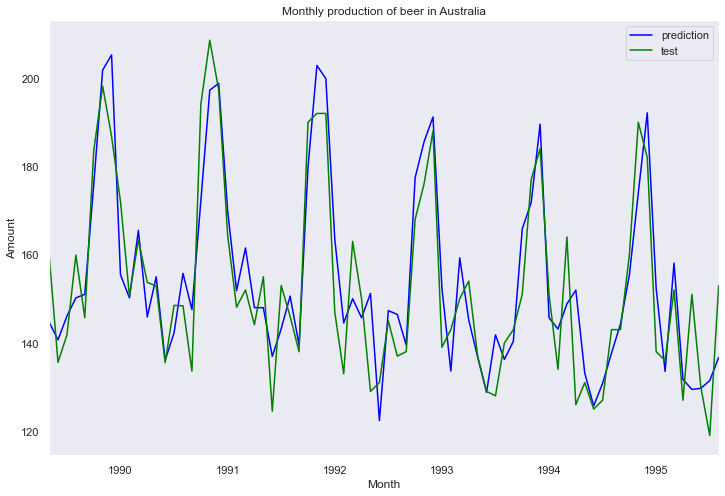

In [108]:
pd.DataFrame(data={'prediction':predictions}, index=y_test.index).plot(c='blue')
y_test.plot(label='test', c='green')
plt.title('Monthly production of beer in Australia')
plt.ylabel('Amount')
plt.xlabel('Month')
plt.legend()
plt.grid()
plt.show()

In [69]:
    mse = metrics.mean_squared_error(y_test.values,predictions)
    mae = metrics.mean_absolute_error(y_test.values,predictions)
    rmse = np.sqrt(metrics.mean_squared_error(y_test.values,predictions))
    mape = mean_absolute_percentage_error(y_test.values,predictions)
    r2 = metrics.r2_score(y_test.values,predictions)
    
    print('Evaluation metric results:')
    print(f'MSE is : {mse}')
    print(f'MAE is : {mae}')
    print(f'RMSE is : {rmse}')
    print(f'MAPE is : {mape}')
    print(f'R2 is : {r2}',end='\n\n')

Evaluation metric results:
MSE is : 102.46685105912191
MAE is : 8.22273672003495
RMSE is : 10.12259112377468
MAPE is : 0.05409360858345892
R2 is : 0.7747392755390505



The metrics of the Linear Regression are promising, however SARIMA performed better.

# Exponential Smoothing

In [70]:
# Splitting
train1 = dfbeer.loc[:'1994-08-01']; train1
test1 = dfbeer.loc['1994-09-01':]; test1

,Month,Monthly beer production,Year,production_log,production_log_diff_1
Month,,,,,
1994-09-01,9,143.0,1994,4.962845,0.000000
1994-10-01,10,160.0,1994,5.075174,0.112329
1994-11-01,11,190.0,1994,5.247024,0.171850
1994-12-01,12,182.0,1994,5.204007,-0.043017
1995-01-01,1,138.0,1995,4.927254,-0.276753
1995-02-01,2,136.0,1995,4.912655,-0.014599
1995-03-01,3,152.0,1995,5.023881,0.111226
1995-04-01,4,127.0,1995,4.844187,-0.179693
1995-05-01,5,151.0,1995,5.017280,0.173093


In [71]:
# Model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(train1['Monthly beer production'], # takes means from the last inputs, the latest inputs are more important
                             trend='mul',
                             seasonal='add',
                             seasonal_periods=12).fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [72]:
# Prediction
start = len(test1)
pred = model.forecast(start).rename('prediction'); pred

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


1994-09-01    132.529116
1994-10-01    159.593669
1994-11-01    169.957699
1994-12-01    180.216770
1995-01-01    143.836743
1995-02-01    132.930651
1995-03-01    147.113061
1995-04-01    133.318087
1995-05-01    128.105995
1995-06-01    115.533388
1995-07-01    125.777916
1995-08-01    129.268568
Freq: MS, Name: prediction, dtype: float64

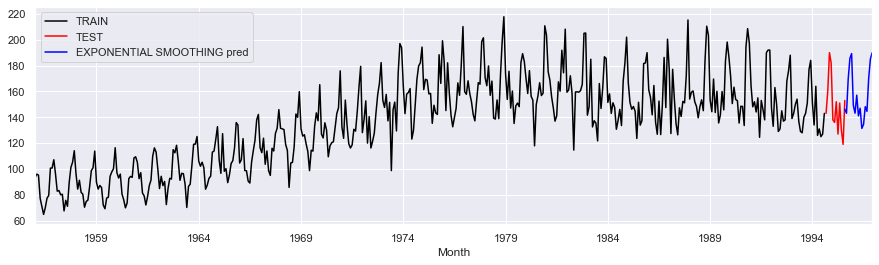

In [97]:
# Plot
train1['Monthly beer production'].plot(legend=True, label='TRAIN', c='black', figsize=(15,4))
test1['Monthly beer production'].plot(legend=True, label='TEST', c='red', figsize=(15,4))
pred.plot(legend=True, label='EXPONENTIAL SMOOTHING pred', c='blue');

In [74]:
# Evaluation
print('Evaluation metric results:')
print('MSE: ', round(np.sqrt(mean_squared_error(test1['Monthly beer production'], pred)),4))
print('MAE: ', round(np.sqrt(mean_absolute_error(test1['Monthly beer production'], pred)),4))
print('RMSE: ', round(np.sqrt(mean_squared_error(test1['Monthly beer production'], pred)),4))
print('MAPE: ', round(np.sqrt(mean_absolute_percentage_error(test1['Monthly beer production'], pred)),4))
print('R2: ', round(np.sqrt(r2_score(test1['Monthly beer production'], pred)),4))

Evaluation metric results:
MSE:  12.7949
MAE:  3.1713
RMSE:  12.7949
MAPE:  0.2603
R2:  0.7785


# Final Prediction

After analyzing each model separately, we conclude that SARIMA recorded the best values ​​in RMSE, MAPE and R2. Thus, we will use this model to predict beer production for 1996.

In [75]:
dfbeer.head()

,Month,Monthly beer production,Year,production_log,production_log_diff_1
Month,,,,,
1956-01-01,1,93.2,1956,4.534748,NaN
1956-02-01,2,96.0,1956,4.564348,0.029600
1956-03-01,3,95.2,1956,4.555980,-0.008368
1956-04-01,4,77.1,1956,4.345103,-0.210877
1956-05-01,5,70.9,1956,4.261270,-0.083833


In [76]:
train = dfbeer.loc['1975-01-01':]; train

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['Monthly beer production'], order=(2, 1, 3), seasonal_order=(1, 0, 2, 12)) #adding values
results = model.fit()
results.summary()

start = len(train) - 1 # to have the last current observation
end = len(train) + 16 - 1 # till the end of 1995 + whole year 1996 - 1 (1997-01-01)

pred = results.predict(start, end).rename('log_Sarima'); pred


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


1995-08-01    146.246026
1995-09-01    143.093230
1995-10-01    169.702013
1995-11-01    185.614436
1995-12-01    189.264476
1996-01-01    149.271495
1996-02-01    143.162832
1996-03-01    157.076674
1996-04-01    141.085205
1996-05-01    146.991150
1996-06-01    131.373493
1996-07-01    134.504725
1996-08-01    148.206536
1996-09-01    144.578807
1996-10-01    169.941559
1996-11-01    184.929944
1996-12-01    189.868344
Freq: MS, Name: log_Sarima, dtype: float64

In [77]:
year_1996 = pd.DataFrame(pred); print(year_1996.loc['1996-01-01':'1996-12-01'])

            log_Sarima
1996-01-01  149.271495
1996-02-01  143.162832
1996-03-01  157.076674
1996-04-01  141.085205
1996-05-01  146.991150
1996-06-01  131.373493
1996-07-01  134.504725
1996-08-01  148.206536
1996-09-01  144.578807
1996-10-01  169.941559
1996-11-01  184.929944
1996-12-01  189.868344


# Conclusion
In this project we analyzed the database and systematically prepared the steps for the forecast of monthly Australian beer production for the year 1996. We used 3 analysis models: SARIMA, Linear Regression and Exponential Smoothing. After checking the values of each model, SARIMA proved to be the best. We consider that other improvements can be made if more variables are taken into consideration when we are analyzing the beer production. This would lead to the choice of other models of analysis with greater accuracy.